In [ ]:


!pip install qiskit matplotlib numpy scipy plotly pandas scikit-learn torch gym stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install qiskit qiskit-aer gym stable-baselines3 matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.4 MB/s eta 0:00:00


In [ ]:
!pip install qiskit qiskit-aer stable-baselines3 matplotlib gymnasium shimmy

INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.


In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Quantum Realm/models/ppo_quantum_interaction"
# Save the trained model

os.makedirs(os.path.dirname(path), exist_ok=True)

Mounted at /content/drive


In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import gymnasium as gym
from gymnasium import spaces
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from qiskit.visualization import plot_state_qsphere

class QuantumEnvironment(gym.Env):
    def __init__(self, num_qubits=3):
        super(QuantumEnvironment, self).__init__()
        self.num_qubits = num_qubits
        self.qc = QuantumCircuit(num_qubits)
        self.backend = Aer.get_backend('statevector_simulator')

        # Define action and observation space
        self.action_space = spaces.Discrete(4 * num_qubits)  # 4 gates (I, X, Y, Z) for each qubit
        self.observation_space = spaces.Box(low=-1, high=1, shape=(2 ** num_qubits * 2,), dtype=np.float32)

        self.target_state = None
        self.current_step = 0
        self.max_steps = 50

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.qc = QuantumCircuit(self.num_qubits)
        self.current_step = 0

        # Generate a random target state
        target_qc = QuantumCircuit(self.num_qubits)
        for _ in range(self.np_random.integers(1, 5)):
            target_qc.h(self.np_random.integers(0, self.num_qubits))
        job = self.backend.run(target_qc)
        self.target_state = job.result().get_statevector()

        return self._get_observation(), {}

    def step(self, action):
        gate = action % 4
        qubit = action // 4

        if gate == 0:  # I gate (do nothing)
            pass
        elif gate == 1:  # X gate
            self.qc.x(qubit)
        elif gate == 2:  # Y gate
            self.qc.y(qubit)
        elif gate == 3:  # Z gate
            self.qc.z(qubit)

        self.current_step += 1

        obs = self._get_observation()
        reward = self._get_reward()
        done = self.current_step >= self.max_steps

        return obs, reward, done, False, {}

    def _get_observation(self):
        job = self.backend.run(self.qc)
        statevector = job.result().get_statevector()
        return np.concatenate([statevector.real, statevector.imag]).astype(np.float32)

    def _get_reward(self):
        current_state = self._get_observation()
        target_state = np.concatenate([self.target_state.real, self.target_state.imag])
        fidelity = np.abs(np.dot(current_state, target_state)) ** 2
        return fidelity - 1  # Reward is in [-1, 0], with 0 being a perfect match





In [10]:
# Create and wrap the environment
env = QuantumEnvironment(num_qubits=3)
env = DummyVecEnv([lambda: env])

# Initialize the agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)  # Reduced for quicker execution in Colab

print("Training completed!")

# Save the trained model
model.save(path)
print(f"Model saved to {path}")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 343  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 297          |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0019024608 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.48        |
|    explained_variance   | -0.0178      |
|    learning_rate        | 0.0003       |
|    loss                 | 12.2         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00848     |
|    value_loss           | 91           |
------------------------------------------

Model loaded from /content/drive/My Drive/Colab Notebooks/Quantum Realm/models/ppo_quantum_interaction


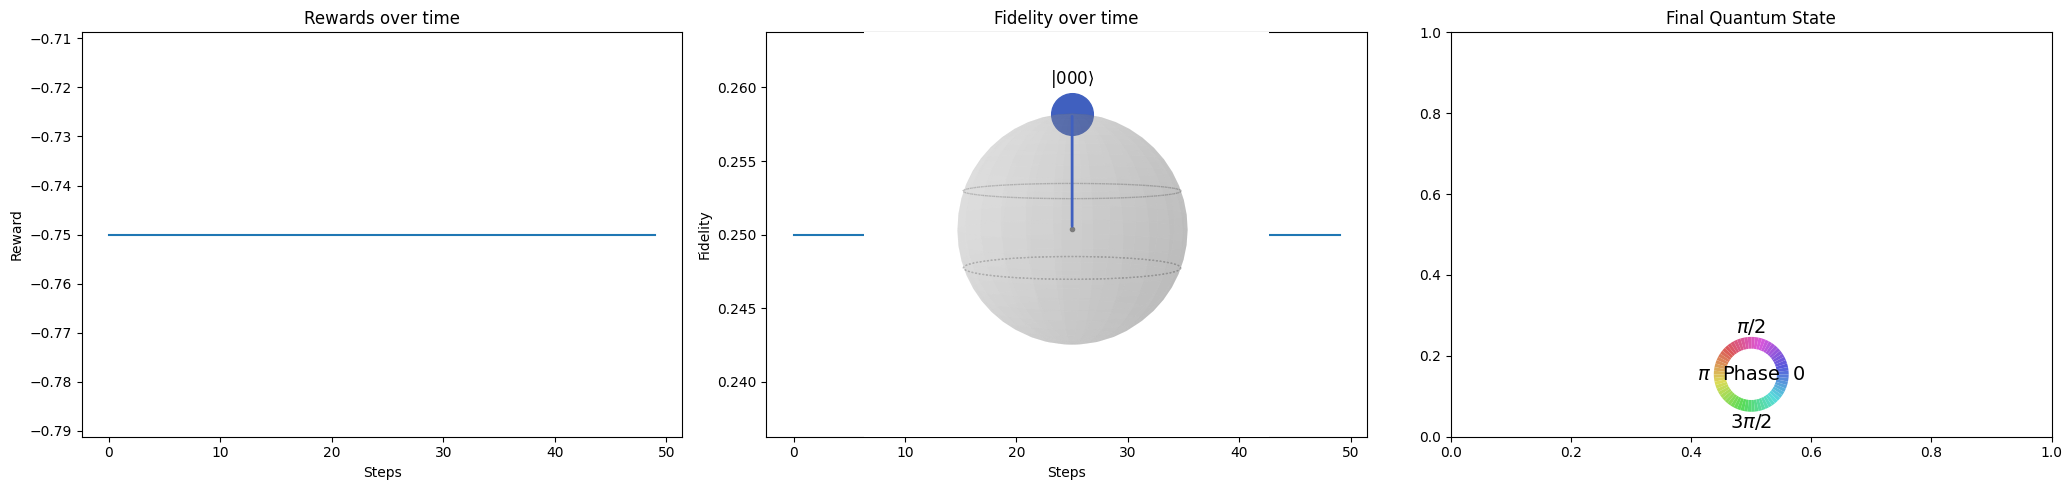

Sequence of gates applied:
Step 1: x on qubit [Qubit(QuantumRegister(3, 'q'), 2)]
Step 2: z on qubit [Qubit(QuantumRegister(3, 'q'), 2)]
Step 3: x on qubit [Qubit(QuantumRegister(3, 'q'), 1)]
Step 4: x on qubit [Qubit(QuantumRegister(3, 'q'), 2)]
Step 5: x on qubit [Qubit(QuantumRegister(3, 'q'), 1)]


In [11]:
# Test the trained agent
model = PPO.load(path)
print(f"Model loaded from {path}")
env = QuantumEnvironment(num_qubits=3)
obs, _ = env.reset()

# Lists to store data for plotting
steps = []
rewards = []
fidelities = []

# Run the simulation
for i in range(50):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)

    steps.append(i)
    rewards.append(reward)
    fidelities.append(1 + reward)  # Convert reward back to fidelity

    if done:
        break

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot rewards
ax1.plot(steps, rewards)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Reward')
ax1.set_title('Rewards over time')

# Plot fidelities
ax2.plot(steps, fidelities)
ax2.set_xlabel('Steps')
ax2.set_ylabel('Fidelity')
ax2.set_title('Fidelity over time')

# Plot final quantum state
final_state = env._get_observation()[:len(env._get_observation())//2] + 1j * env._get_observation()[len(env._get_observation())//2:]
plot_state_qsphere(final_state, ax=ax3)
ax3.set_title('Final Quantum State')

plt.tight_layout()
plt.show()

# Print the sequence of gates applied
print("Sequence of gates applied:")
for i, action in enumerate(env.qc.data):
    print(f"Step {i+1}: {action[0].name} on qubit {action[1]}")